In [1]:
import pymaid

url = "https://neurophyla.mrc-lmb.cam.ac.uk/catmaid/fibsem/#"
token = "4fe0c0572331265c61bf6ba4acd77cbed9792276"
name = "SYLee"
password = "Blue Skies"
# project_id = 19
project_id = 18
rm = pymaid.CatmaidInstance(url, token, name, password, project_id)

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


In [ ]:
# Read the CSV
neuron = pymaid.get_neuron('annotation: cube2: pushed fp synapses')
print(type(neuron))
skids = [n.skeleton_id for n in neuron]  
print(skids)  

In [ ]:
import pandas as pd
import pymaid
import time

import pandas as pd
import pymaid
import time

# Fetch neuron data
neuron = pymaid.get_neuron('annotation: cube2: pushed fp synapses')
skids = [n.skeleton_id for n in neuron]  # Extract skeleton IDs

# Function to split list into chunks of size 250
def chunk_list(lst, chunk_size=250):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Dictionary to store annotations
annotations_dict = {}

# Process in batches of 250
for batch in chunk_list(skids, 250):
    try:
        annotations = pymaid.get_annotations(batch)  # Fetch annotations
        # Remove unwanted annotations while fetching
        for skel_id, ann_list in annotations.items():
            filtered_annotations = [ann for ann in ann_list if ann not in {"cube2: pushed fp synapses", "pushed false positives synapses"}]
            annotations_dict[skel_id] = filtered_annotations  # Store only cleaned annotations
    except Exception as e:
        print(f"Error fetching annotations for batch {batch}: {e}")
    time.sleep(1)  # Avoid overloading the server

# Convert dictionary to DataFrame
annotations_df = pd.DataFrame(list(annotations_dict.items()), columns=['skeleton_id', 'annotations'])

# Expand the list of annotations into separate columns
annotations_expanded = annotations_df['annotations'].apply(pd.Series)

# Rename columns dynamically (Annotation_1, Annotation_2, etc.)
annotations_expanded.columns = [f'Annotation_{i+1}' for i in range(annotations_expanded.shape[1])]

# Combine skeleton_id with expanded annotations
annotations_df = pd.concat([annotations_df[['skeleton_id']], annotations_expanded], axis=1)

# Save the updated DataFrame
annotations_df.to_csv('~/Documents/CATMAID/pymaid/9_analysisfromproofread/analysis_proofread_octo2.csv', index=False)

print("CSV updated successfully!")

In [33]:
annotations_df

,skeleton_id,Annotation_1,Annotation_2,Annotation_3,Annotation_4,Annotation_5,Annotation_6,Annotation_7,Annotation_8,Annotation_9,Annotation_10
0,608126,distanced set,ad: pre correct,ad: distanced set,sh: distanced set,mc: pre correct,mc: distance set,acs: pre correct,mr:distanced,mr: uncertain,syl: uncertain
1,608131,pre correct,ad: pre correct,sh: distanced set,mc: pre correct,acs: pre correct,mr: pre correct,NaN,NaN,NaN,NaN
2,608135,wrong set,mc: wrong set,sh: wrong set,ad: wrong set,acs: wrong set,mr: wrong set,syl: incorrect,NaN,NaN,NaN
3,608139,distanced set,mc: wrong set,sh: uncertain,ad: wrong set,acs: wrong set,mr: uncertain,syl: uncertain,NaN,NaN,NaN
4,608143,wrong set,mc: wrong set,sh: wrong set,ad: wrong set,acs: wrong set,mr: wrong set,syl: incorrect,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
281,609262,mr: pre correct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
282,609266,mr: distanced set,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,609270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
284,609274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
import pandas as pd

df = annotations_df.copy()

unique_annotations = set()

for col in df.columns[1:]:
    for annotation in df[col].dropna():
        # Handle cells that might be lists or strings
        if isinstance(annotation, list):
            annotations_list = annotation
        else:
            annotations_list = [annotation]

        for single_annotation in annotations_list:
            unique_annotations.add(single_annotation.strip())

# Print sorted unique annotations
for annotation in sorted(unique_annotations):
    print(annotation)


acs: pre correct
acs: uncertain
acs: wrong set
ad: distanced set
ad: pre correct
ad: uncertain
ad: wrong set
mc: distance set
mc: pre correct
mc: uncertain
mc: unknown
mc: wrong set
mr: distanced set
mr: pre correct
mr: uncertain
mr: wrong set
mr:distanced
sh: distanced set
sh: pre correct
sh: uncertain
sh: wrong set
syl: correct
syl: incorrect
syl: uncertain


In [5]:
user_annotations_mapping = {
    "acs": ["acs: pre correct", "acs: uncertain", "acs: wrong set"],
    "ad": ["ad: pre correct", "ad: distanced set", "ad: uncertain", "ad: wrong set"],
    "mc": ["mc: distance set","mc: pre correct","mc: uncertain","mc: unknown","mc: wrong set"],
    "mr": ["mr: distanced set","mr: pre correct","mr: uncertain","mr: wrong set","mr:distanced"],
    "sh": ["sh: wrong set", "sh: distanced set", "sh: pre correct","sh: uncertain"],
    "syl": ["syl:correct","syl: uncertain", "syl: incorrect"],
}


In [11]:
import pandas as pd
import re

import pandas as pd

# Example: your original DataFrame
df = annotations_df.copy()

structured_data_list = []

# Iterate over every row in the DataFrame
for idx, row in df.iterrows():
    structured_row = {"skeleton_id": row["skeleton_id"]}
    for annotation in row[1:]:
        matched = False
        for user_prefix, annotations_list in user_annotations_mapping.items():
            for full_annotation in annotations_list:
                # normalize strings to match consistently
                if isinstance(annotation, str) and annotation.replace(" ", "").lower() == full_annotation.replace(" ", "").lower():
                    classification = full_annotation.split(":")[1].strip()
                    structured_row[user_prefix] = classification
                    matched = True
                    break
            if matched:
                break
    structured_data_list.append(structured_row)

# Convert the list of structured rows into a DataFrame
structured_df = pd.DataFrame(structured_data_list)

# Reorder columns
ordered_cols = ["skeleton_id"] + sorted(user_annotations_mapping.keys())
structured_df = structured_df.reindex(columns=ordered_cols)

# Fill missing values
structured_df.fillna('', inplace=True)

display(structured_df)


,skeleton_id,acs,ad,mc,mr,sh,syl
0,608126,pre correct,distanced set,distance set,uncertain,distanced set,uncertain
1,608131,pre correct,pre correct,pre correct,pre correct,distanced set,correct
2,608135,wrong set,wrong set,wrong set,wrong set,wrong set,incorrect
3,608139,wrong set,wrong set,wrong set,uncertain,uncertain,uncertain
4,608143,wrong set,wrong set,wrong set,wrong set,wrong set,incorrect
...,...,...,...,...,...,...,...
281,609262,,,,pre correct,,
282,609266,,,,distanced set,,
283,609270,,,,,,
284,609274,,,,,,


In [12]:
import pandas as pd

# Assuming your DataFrame is named df
classifications = set()

for col in structured_df.columns[1:]:  # Exclude skeleton_id
    classifications.update(structured_df[col].dropna().unique())

print("Unique classifications:")
for classification in sorted(classifications):
    if classification.strip():
        print(classification)


Unique classifications:
correct
distance set
distanced
distanced set
incorrect
pre correct
uncertain
unknown
wrong set


In [13]:
group_mapping = {
    "correct": "correct",
    "pre correct": "correct",
    "distance set": "uncertain",
    "distanced" : "uncertain",
    "distanced set": "uncertain",
    "uncertain": "uncertain",
    "wrong set": "incorrect",
    "incorrect": "incorrect",
}

In [21]:
import pandas as pd

grouped_df = structured_df.copy()

# Apply mapping
for col in grouped_df.columns[1:]:
    grouped_df[col] = grouped_df[col].map(group_mapping).fillna('')

# Calculate annotations_per_user (how many annotations each user made)
annotations_per_user = ['annotations_per_user']
for col in grouped_df.columns[1:]:
    annotations_per_user.append(grouped_df[col].astype(bool).sum())

# Insert annotations_per_user row below column headers
annotations_row_df = pd.DataFrame([annotations_per_user], columns=grouped_df.columns)

# Calculate annotations_per_neuron (annotations count per row)
grouped_df['annotations_per_neuron'] = grouped_df.iloc[:, 1:].astype(bool).sum(axis=1)

# Concatenate the annotations_per_user row with the existing DataFrame
final_df = pd.concat([annotations_row_df, grouped_df], ignore_index=True)

# Display the resulting DataFrame
display(final_df.head())

# # Save to CSV
final_df.to_csv('~/Documents/CATMAID/pymaid/9_analysisfromproofread/classificationocto2.csv', index=False)


,skeleton_id,acs,ad,mc,mr,sh,syl,annotations_per_neuron
0,annotations_per_user,153,94,49,107,59,33,NaN
1,608126,correct,uncertain,uncertain,uncertain,uncertain,uncertain,6.0
2,608131,correct,correct,correct,correct,uncertain,correct,6.0
3,608135,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,6.0
4,608139,incorrect,incorrect,incorrect,uncertain,uncertain,uncertain,6.0


In [16]:
numeric_mapping = {"correct": 1, "distanced": 0.5, "incorrect": 0}

numeric_df = grouped_df.copy()

for col in numeric_df.columns[1:]:
    numeric_df[col] = numeric_df[col].map(numeric_mapping)

# Calculate the mean classification per row, skipping empty entries
numeric_df['average_classification'] = numeric_df.iloc[:, 1:].mean(axis=1, skipna=True)

print(numeric_df[['skeleton_id', 'average_classification']].head())


  skeleton_id  average_classification
0      608126                     1.0
1      608131                     1.0
2      608135                     0.0
3      608139                     0.0
4      608143                     0.0


In [19]:
#If xx is the standard 

reference_col = 'acs'  # Your reference column
match_percentages = {}

# Count total annotations made by acs (excluding empty cells)
total_annotations_acs = grouped_df[reference_col].astype(bool).sum()

# Iterate over each column (excluding skeleton_id and reference_col)
for col in grouped_df.columns:
    if col not in ['skeleton_id', reference_col]:
        # Count matches only where acs has an annotation
        matches = (grouped_df[col] == grouped_df[reference_col]) & (grouped_df[reference_col] != '')
        num_matches = matches.sum()

        # Calculate match percentage
        percentage = (num_matches / total_annotations_acs) * 100 if total_annotations_acs else 0
        match_percentages[col] = percentage

# Sort results by highest percentage match
sorted_percentages = sorted(match_percentages.items(), key=lambda x: x[1], reverse=True)

# Display results
percentages_df = pd.DataFrame(sorted_percentages, columns=['Column', 'Match_Percentage_with_acs'])
print(percentages_df)

  Column  Match_Percentage_with_acs
0     ad                  31.372549
1     mc                  20.261438
2     sh                  17.647059
3     mr                  16.993464
4    syl                   9.150327


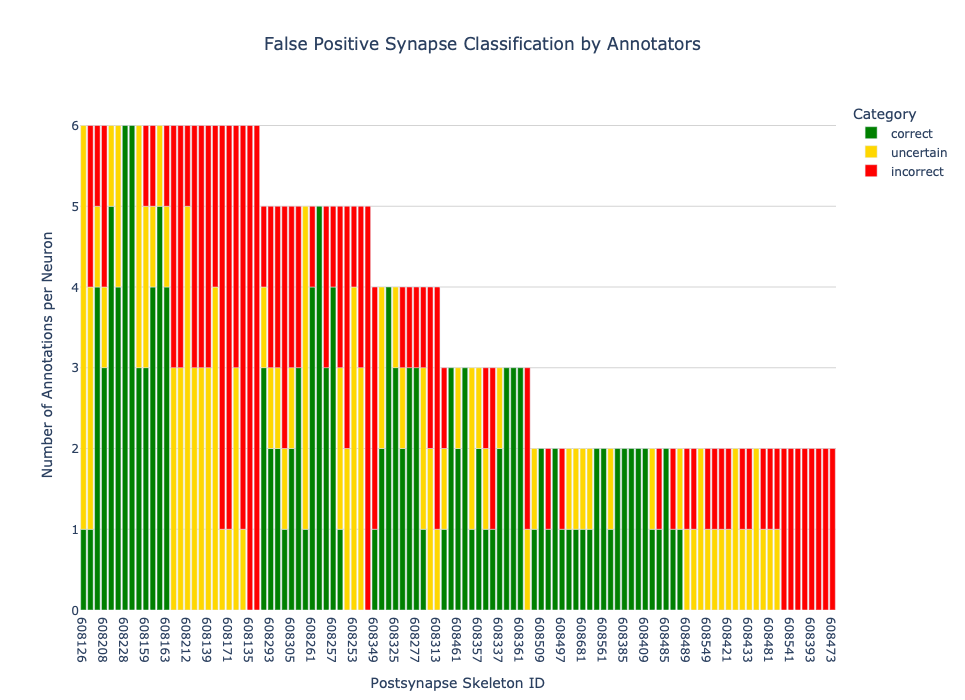

In [72]:
import pandas as pd
import plotly.express as px


# Convert to DataFrame
df = pd.read_csv('~/Documents/CATMAID/pymaid/9_analysisfromproofread/octo_cube2/classificationocto2.csv')
annotators = df.columns[1:-1].tolist()

# Remove rows where 'annotations_per_neuron' is less than 1
df_filtered = df[df["annotations_per_neuron"] >= 2]

# Sort by 'annotations_per_neuron' in descending order
df_filtered = df_filtered.sort_values(by="annotations_per_neuron", ascending=False)

# Extract annotators (excluding 'skeleton_id' and 'annotations_per_neuron')
annotators = df_filtered.columns[1:-1].tolist()

# Transform data for visualization
df_melted = df_filtered.melt(id_vars=["skeleton_id", "annotations_per_neuron"], 
                             value_vars=annotators, 
                             var_name="Annotator", 
                             value_name="Category")

# Group by skeleton_id and category to count occurrences and aggregate annotators
df_summary = df_melted.groupby(["skeleton_id", "Category"]).agg(
    Annotation=("Category", "count"),  # Count occurrences
    Annotators=("Annotator", lambda x: ", ".join(sorted(x)))  # List annotators
).reset_index()

# Merge to keep annotations per neuron
df_summary = df_summary.merge(df_filtered[["skeleton_id", "annotations_per_neuron"]].drop_duplicates(), on="skeleton_id")

# **NEW FIX**: Ensure skeleton_id is sorted by annotations_per_neuron before plotting
df_summary = df_summary.sort_values(by="annotations_per_neuron", ascending=False)

# Plot with Plotly Express, adding hover text with annotators
fig = px.bar(df_summary, 
             x="skeleton_id", 
             y="Annotation", 
             color="Category",
             title="False Positive Synapse Classification by Annotators",
             color_discrete_map={"correct": "green", "uncertain": "gold", "incorrect": "red"},
             hover_data={"Annotators": True, "annotations_per_neuron": True})

# Update layout
fig.update_layout(
    width=1000, 
    height=700,
    title={
        'text': 'False Positive Synapse Classification by Annotators',
        'x': 0.5,
        'xanchor': 'center'
    },
    yaxis=dict(
        title="Number of Annotations per Neuron",
        showgrid=True,
        gridcolor='lightgray',
        gridwidth=1
    ),
    xaxis=dict(
        title="Postsynapse Skeleton ID",
        categoryorder="total descending"  
    ),
    plot_bgcolor='white'
)

# Show figure
fig.show()
fig.write_html("annotations_plot.html")


In [54]:
import pandas as pd
import numpy as np

df= final_df 

# Mapping for confidence values
confidence_mapping = {'correct': 1, 'uncertain': 0.5, 'incorrect': 0}

# Function to calculate confidence
def calculate_confidence(row):
    values = [confidence_mapping.get(v, np.nan) for v in row[['acs', 'ad', 'mc', 'mr', 'sh', 'syl']]]
    values = [v for v in values if not np.isnan(v)]
    if len(values) >= 2:
        return np.mean(values)
    else:
        return 'not enough data'

# Apply confidence calculation
df['confidence_level'] = df.apply(calculate_confidence, axis=1)

# Display updated dataframe
display(df)

df.to_csv('results.csv',index=False)

,skeleton_id,acs,ad,mc,mr,sh,syl,annotations_per_neuron,confidence_level,closest_assumption
0,annotations_per_user,153,94,49,107,59,33,NaN,not enough data,NaN
1,608126,correct,uncertain,uncertain,uncertain,uncertain,uncertain,6.0,0.583333,ad
2,608131,correct,correct,correct,correct,uncertain,correct,6.0,0.916667,acs
3,608135,incorrect,incorrect,incorrect,incorrect,incorrect,incorrect,6.0,0.0,acs
4,608139,incorrect,incorrect,incorrect,uncertain,uncertain,uncertain,6.0,0.25,acs
...,...,...,...,...,...,...,...,...,...,...
282,609262,,,,correct,,,1.0,not enough data,NaN
283,609266,,,,uncertain,,,1.0,not enough data,NaN
284,609270,,,,,,,0.0,not enough data,NaN
285,609274,,,,,,,0.0,not enough data,NaN


In [53]:
df = final_df

# Mapping for confidence values
confidence_mapping = {'correct': 1, 'uncertain': 0.5, 'incorrect': 0}

# Function to calculate confidence
def calculate_confidence(row):
    values = [confidence_mapping.get(v, np.nan) for v in row[['acs', 'ad', 'mc', 'mr', 'sh', 'syl']]]
    values = [v for v in values if not np.isnan(v)]
    if len(values) >= 2:
        return np.mean(values)
    else:
        return np.nan

# Apply confidence calculation
df['confidence_level'] = df.apply(calculate_confidence, axis=1)

# Calculate average normalized difference per annotator
annotators = ['acs', 'ad', 'mc', 'mr', 'sh', 'syl']
avg_diffs = {}

for annotator in annotators:
    diffs = []
    for _, row in df.iterrows():
        if isinstance(row['confidence_level'], float) and row['confidence_level'] > 0:
            annotator_value = confidence_mapping.get(row[annotator], np.nan)
            if not np.isnan(annotator_value):
                dif = abs(annotator_value - row['confidence_level']) / row['confidence_level']
                diffs.append(dif)
    if diffs:
        avg_diff = np.mean(diffs)
        avg_diffs[annotator] = avg_diff

# Determine best annotator (lowest difference)
best_annotator = min(avg_diffs, key=avg_diffs.get)

# Display results
print("Annotator average normalized differences:", avg_diffs)
print(f"\nBest Annotator: {best_annotator} with lowest average normalized difference: {avg_diffs[best_annotator]:.4f}")


Annotator average normalized differences: {'acs': 0.5499845392702536, 'ad': 0.582699261522791, 'mc': 0.6129070205157162, 'mr': 0.5699454866121533, 'sh': 0.6218460111317254, 'syl': 0.9077084206116466}

Best Annotator: acs with lowest average normalized difference: 0.5500
